In [70]:
import os, torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
import numpy as np, matplotlib.pyplot as plt, pandas as pd

In [28]:
# create a model class that inherits nn.Module
class Model(nn.Module):
    def __init__(self, input_features=3, h1=8, h2=9, output_features=7):
        super().__init__()pip3 install --upgrade pip
        self.fc1 = nn.Linear(input_features,h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, output_features)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [29]:
torch.manual_seed(3)

model = Model()

# Dataframe

In [3]:
df100 = pd.read_csv('data/100.csv')
df100.columns = ['samp_num', 'MLII', 'V5']

In [4]:
df100.head()

,samp_num,MLII,V5
0,0,995,1011
1,1,995,1011
2,2,995,1011
3,3,995,1011
4,4,995,1011


# Reference

In [5]:
ref100 = pd.read_table('data/100annotations.txt',delimiter = '\t')

In [6]:
list(ref100.columns.values)

['      Time   Sample #  Type  Sub Chan  Num', 'Aux']

rpeak

In [7]:
ref100.columns = ['6', 'Sample']

normality

In [45]:
refNormal = []
refRpeak = []
for index, row in ref100.iterrows():
    if index % 500 == 0:
        print(index)
    if ref100['6'][index].split()[2] == 'N' or ref100['6'][index].split()[2] == 'A':
        refNormal.append(ref100['6'][index].split()[2]) 
        refRpeak.append(ref100['6'][index].split()[1]) 
print('finish')

0
500
1000
1500
2000
finish


In [46]:
refRpeak[:5]

['77', '370', '662', '946', '1231']

In [47]:
refNormal[:5]

['N', 'N', 'N', 'N', 'N']

convert N to 0 and A to 1

In [48]:
refNormal = [1 if item == 'A' else 0 for item in refNormal]

In [49]:
refNormal[:5]

[0, 0, 0, 0, 0]

In [50]:
print(f"{len(refNormal)} : {len(refRpeak)}")

2272 : 2272


# add to DF

In [53]:
refRpeak = [int(val) for val in refRpeak]

# Create new columns in the DataFrame
df100['rpeak'] = 0
df100['normality'] = 0

# Set 'rpeak' column values to 1 where samp_num is in refRpeak
df100.loc[df['samp_num'].isin(refRpeak), 'rpeak'] = 1

# Set 'normality' column values based on refNormal
df100.loc[df100['rpeak'] == 1, 'normality'] = refNormal

In [62]:
df100.head()

,samp_num,MLII,V5,rpeak,normality
0,0,995,1011,0,0
1,1,995,1011,0,0
2,2,995,1011,0,0
3,3,995,1011,0,0
4,4,995,1011,0,0


# split train test

In [73]:
y = df100[['rpeak', 'normality']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [74]:
# Now you have your training and testing data ready
print("X_train:")
print(X_train)

print("X_test:")
print(X_test)

print("y_train:")
print(y_train)

print("y_test:")
print(y_test)

X_train:
        samp_num  MLII    V5
238811    238811   987   988
9501        9501   934   960
604260    604260   929   954
118629    118629   942   995
151291    151291   955   964
...          ...   ...   ...
644167    644167   981  1007
259178    259178   946   985
365838    365838   979   984
131932    131932   941   993
121958    121958   957   975

[520000 rows x 3 columns]
X_test:
        samp_num  MLII    V5
177288    177288   941   989
238756    238756   974   991
604225    604225   966   974
2838        2838   967   995
586957    586957   981  1001
...          ...   ...   ...
608030    608030   933   996
93289      93289   957   949
540748    540748   956   992
129818    129818   958   988
630474    630474   933   993

[130000 rows x 3 columns]
y_train:
        rpeak  normality
238811      0          0
9501        0          0
604260      0          0
118629      0          0
151291      0          0
...       ...        ...
644167      0          0
259178      0          0

In [78]:
# x to tensors long
X_train_tensor = torch.LongTensor(X_train.to_numpy())
X_test_tensor = torch.LongTensor(X_test.to_numpy())

# y to tensors long
y_train_tensor = torch.LongTensor(y_train.to_numpy())
y_test_tensor = torch.LongTensor(y_test.to_numpy())

In [81]:
# set the citerion of model to measure the error (how off the predictions are from)
criterion = nn.CrossEntropyLoss()
# choose Adam optimiser (lr = learning rate)
optimiser = torch.optim.Adam(model.parameters(), lr =0.01)

# Train model

## First variation function for Rpeak

In [10]:
def detect_r_peaks(ecg_signal, sampling_rate):
    # Derivative to highlight the QRS complex
    diff_signal = np.diff(ecg_signal)

    # Squaring to make all data points positive and emphasize larger differences
    squared_signal = diff_signal ** 2

    # Moving window integration
    window_size = int(0.12 * sampling_rate)  # 120 ms window
    integrated_signal = np.convolve(squared_signal, np.ones(window_size)/window_size, mode='same')

    # Find peaks
    peaks, _ = find_peaks(integrated_signal, distance=sampling_rate/2.5)  
    # assuming at least 0.4 seconds between heartbeats
    
    return peaks

## Second variation function for Rpeak

In [11]:
def detect_r_peaks2(ecg_signal, sampling_rate, threshold_factor=0.85):
    # Find local maxima
    window_size = int(0.12 * sampling_rate)  # 120 ms window, typical for adult human heart rate
    peaks = []

    for i in range(window_size, len(ecg_signal) - window_size):
        window = ecg_signal[i - window_size:i + window_size]
        if ecg_signal[i] == max(window):
            peaks.append(i)

    # Thresholding peaks
    threshold = threshold_factor * max(ecg_signal)
    r_peaks = np.array([peak for peak in peaks if ecg_signal[peak] > threshold])

    return r_peaks

## Third variation function for Rpeak

changed the window to 200ms based on the (2004 BioMedical Engineering OnLine Real time electrocardiogram QRS detection using combined adaptive threshold Ivaylo I Christov*) paper

In [12]:
def detect_r_peaks3(ecg_signal, sampling_rate, threshold_factor=0.85):
    # Find local maxima
    window_size = int(0.2 * sampling_rate)  # 200 ms window
    peaks = []

    for i in range(window_size, len(ecg_signal) - window_size):
        window = ecg_signal[i - window_size:i + window_size]
        if ecg_signal[i] == max(window):
            peaks.append(i)

    # Thresholding peaks
    threshold = threshold_factor * max(ecg_signal)
    r_peaks = np.array([peak for peak in peaks if ecg_signal[peak] > threshold])

    # Calculating RR intervals
    rr_intervals = np.diff(r_peaks) / sampling_rate  # Convert to seconds

    # Normality check for each R-peak based on RR intervals
    r_peak_normality = []
    if len(rr_intervals) > 0:
        mean_rr = np.mean(rr_intervals)
        # For each R-peak, check if the following RR interval is normal
        for i in range(len(r_peaks) - 1):
            is_normal = abs(rr_intervals[i] - mean_rr) < 0.20 * mean_rr
            r_peak_normality.append(is_normal)
        # The last R-peak's normality is assessed based on the last RR interval
        r_peak_normality.append(abs(rr_intervals[-1] - mean_rr) < 0.20 * mean_rr)

    return r_peaks, r_peak_normality

## Loading data and obtaining Rpeak

In [13]:
# Load the data
df = pd.read_csv('data/100.csv')
df.columns = ['samp_num', 'MLII', 'V5']

# Extract the MLII data
mlii_signal = df['MLII'].values

# Define sampling rate
sampling_rate = 360

# Detect R-peaks
r_peaks1 = detect_r_peaks(mlii_signal, sampling_rate)
r_peaks2 = detect_r_peaks2(mlii_signal, sampling_rate)

In [14]:
r_peaks3, is_normal3 = detect_r_peaks3(mlii_signal, sampling_rate)

In [15]:
r_peaks3[:5]

array([  77,  370,  663,  947, 1231])

In [16]:
is_normal3[:5]

[True, True, True, True, True]

# comparing Rpeaks:

In [17]:
peak1 = r_peaks1.tolist()
peak2 = r_peaks2.tolist()

In [18]:
r_peaks1

array([    68,    212,    360, ..., 649475, 649722, 649978])

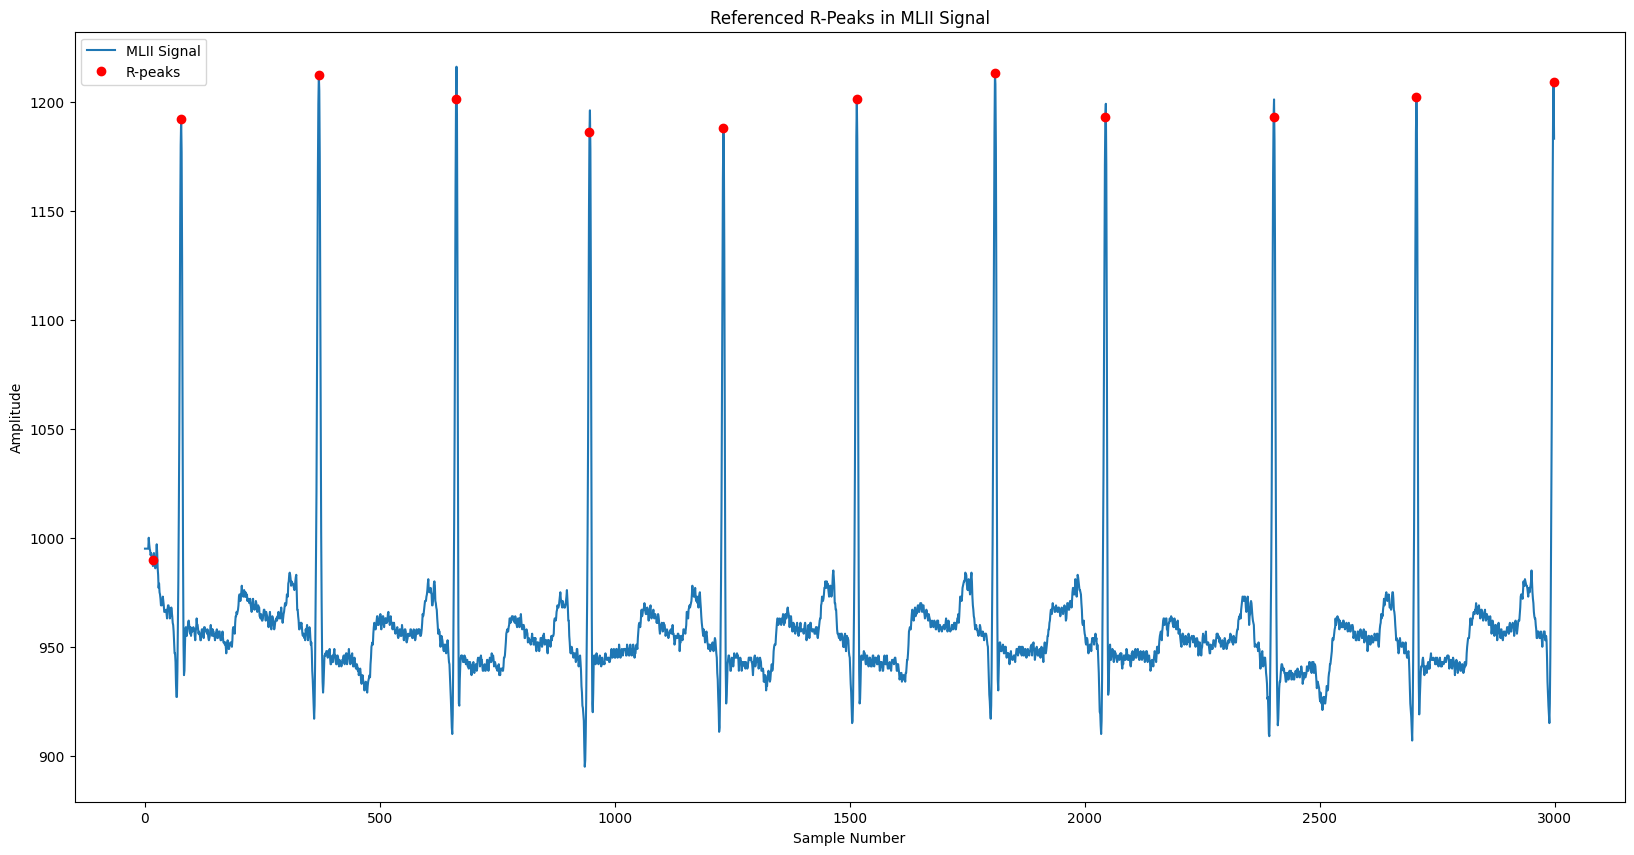

In [19]:
# Slicing the DataFrame
df_x = df.iloc[:3000]

# Filtering R-peaks
r_peaks_x = [int(r_peak) for r_peak in refRpeak if int(r_peak) < 3000]

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(df_x['samp_num'], df_x['MLII'], label='MLII Signal')

# Ensuring that the indices for R-peaks are within the range of the sliced DataFrame
valid_r_peaks_x = df_x['samp_num'].iloc[r_peaks_x]
plt.plot(valid_r_peaks_x, df_x['MLII'].iloc[r_peaks_x], 'ro', label='R-peaks')

plt.title('Referenced R-Peaks in MLII Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

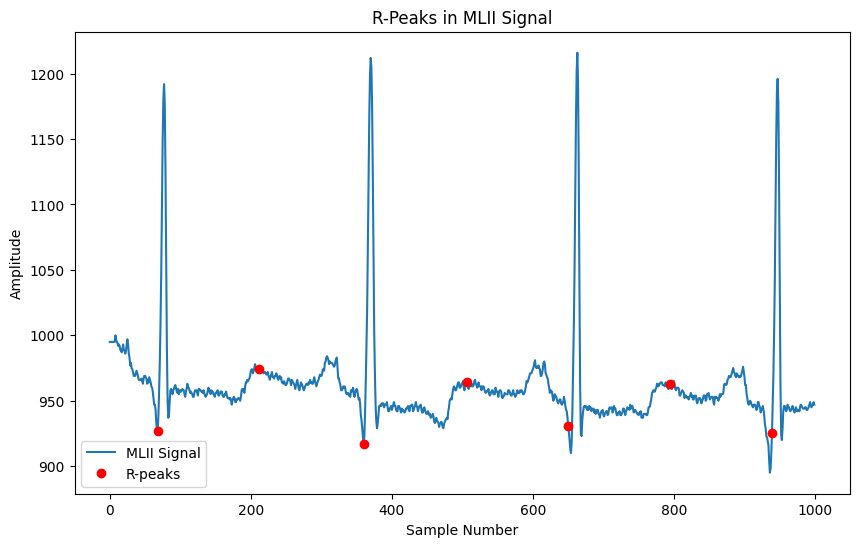

In [20]:
# Slicing the DataFrame
df_x = df.iloc[:1000]

# Filtering R-peaks
r_peaks_x = r_peaks1[r_peaks1 < 1000]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_x['samp_num'], df_x['MLII'], label='MLII Signal')
plt.plot(df_x['samp_num'][r_peaks_x], df_x['MLII'][r_peaks_x], 'ro', label='R-peaks')
plt.title('R-Peaks in MLII Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

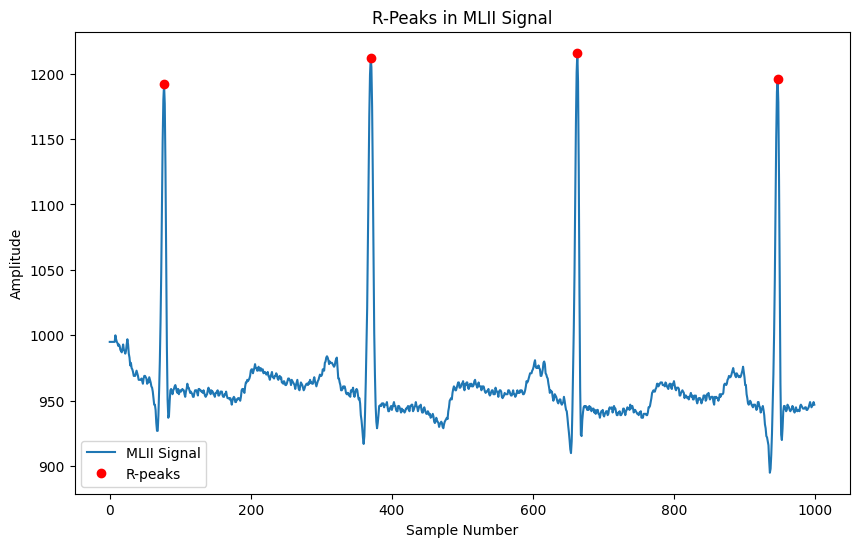

In [21]:
# Slicing the DataFrame
df_x = df.iloc[:1000]

# Filtering R-peaks
r_peaks_x = [peak for peak in r_peaks2 if peak < 1000]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_x['samp_num'], df_x['MLII'], label='MLII Signal')

# Ensuring that the indices for R-peaks are within the range of the sliced DataFrame
valid_r_peaks_x = df_x['samp_num'].iloc[r_peaks_x]
plt.plot(valid_r_peaks_x, df_x['MLII'].iloc[r_peaks_x], 'ro', label='R-peaks')

plt.title('R-Peaks in MLII Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

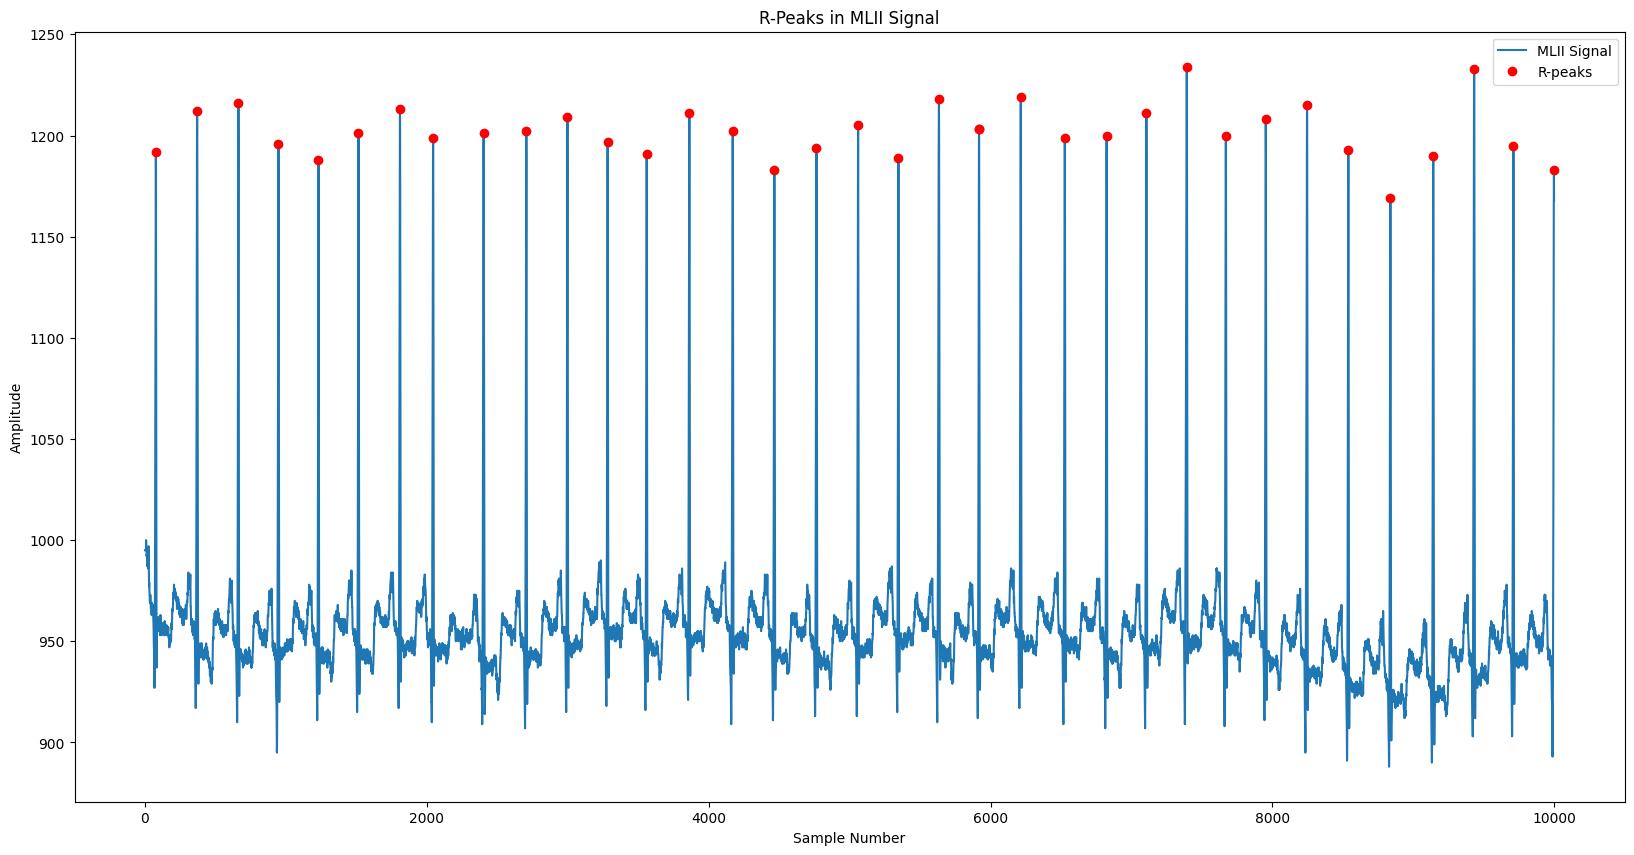

In [22]:
# Slicing the DataFrame
df_x = df.iloc[:10000]

# Filtering R-peaks
r_peaks_x = [peak for peak in r_peaks2 if peak < 10000]

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(df_x['samp_num'], df_x['MLII'], label='MLII Signal')

# Ensuring that the indices for R-peaks are within the range of the sliced DataFrame
valid_r_peaks_x = df_x['samp_num'].iloc[r_peaks_x]
plt.plot(valid_r_peaks_x, df_x['MLII'].iloc[r_peaks_x], 'ro', label='R-peaks')

plt.title('R-Peaks in MLII Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

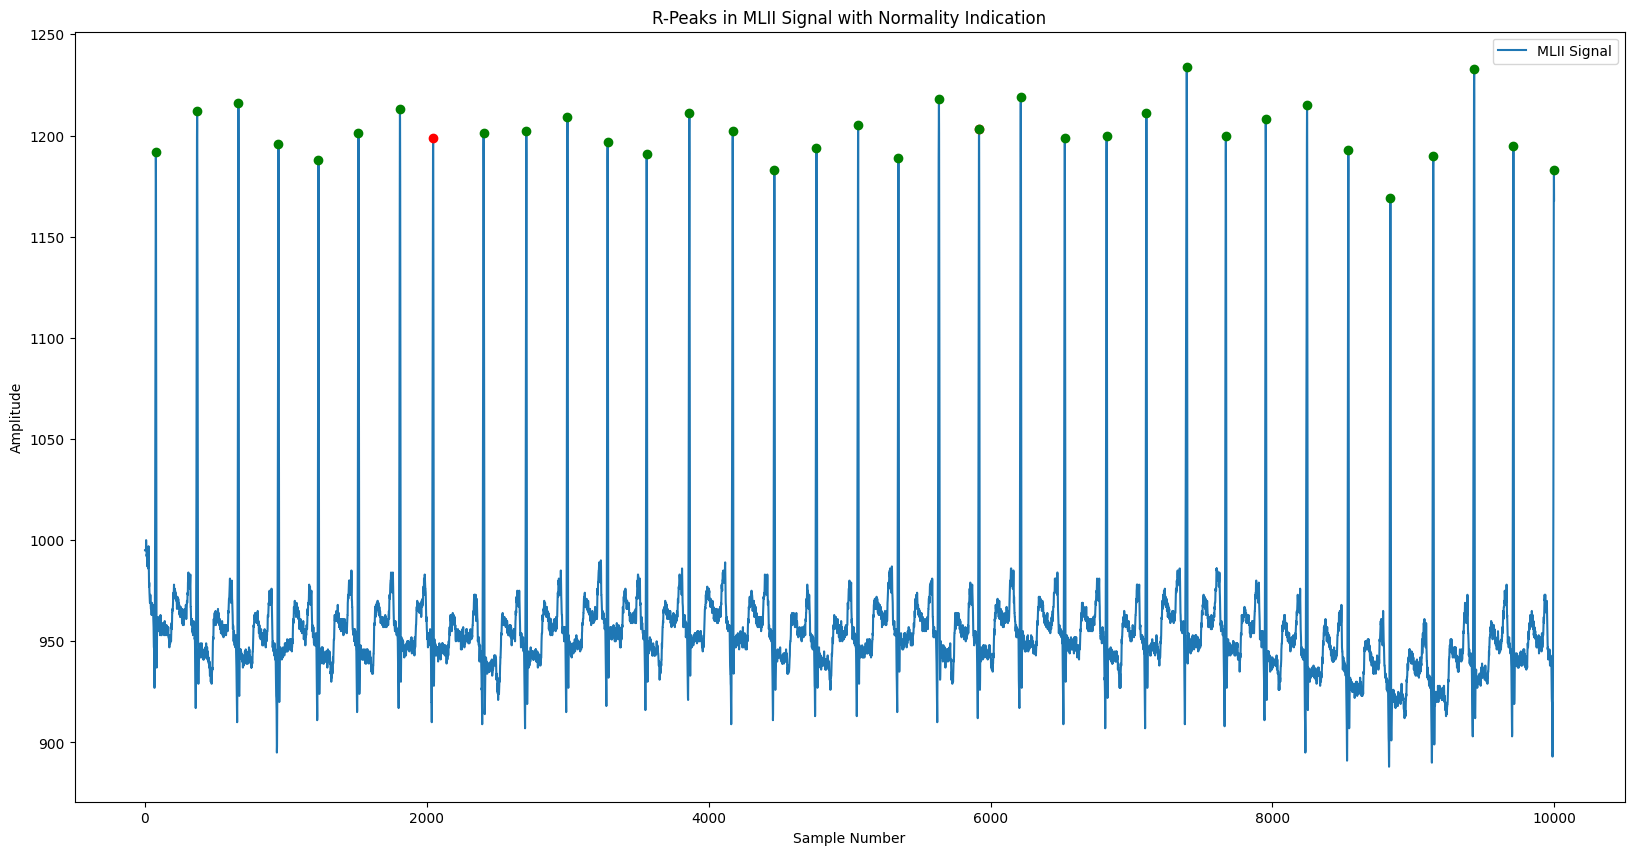

In [23]:
# Slicing the DataFrame
df_x = df.iloc[:10000]

# Filtering R-peaks
r_peaks_x = [peak for peak in r_peaks3 if peak < 10000]
# Filtering corresponding normality booleans
normality_x = is_normal3[:len(r_peaks_x)]

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(df_x['samp_num'], df_x['MLII'], label='MLII Signal')

# Plotting R-peaks with color based on normality
for r_peak, is_normal3 in zip(r_peaks_x, normality_x):
    color = 'green' if is_normal3 else 'red'
    plt.plot(df_x['samp_num'].iloc[r_peak], df_x['MLII'].iloc[r_peak], 'o', color=color)

plt.title('R-Peaks in MLII Signal with Normality Indication')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [24]:
is_normal3

True